In [1]:
## Scikit learn libraries
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

## For NLP
from bs4 import BeautifulSoup, Tag    ## Cleaning HTML tags from text
import nltk, string
from nltk.corpus import stopwords 
import re

## Common Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data I/O
import json     ## To convert json raw data to df
import pickle   ## saving the model to disk

import xgboost as xgb
from scipy.stats import uniform, randint

#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers

## Problem texts can be long and may not load on Jupyter
pd.set_option('display.max_colwidth', -1)    

## Extract subject wise training data

In [2]:
# Load the dataset and show sample question
with open('../data/qs_topicwise.json') as json_data:
    all_questions = json.load(json_data)

subject_model = ['PHY']

## Create empty df 
data_df = pd.DataFrame(columns=['code', 'curriculum', 'subject', 'grade', 'question_text', 'chapter'])

## Removing these words improves Phy clf accuracy by 2% but improves Math classifier accuracy
words_to_remove = ["rightarrow", "hence", "frac", "text", "sqrt", "times", 
                   "value", "amp", "statement", "will", "equal", "number", 
                   "tan", "now", "can", "two", "get", "true", "lambda", "a", "an", "the"]
stop_words = stopwords.words('english')         ## Downloaded from NLTK
'''
Stopwords reduce acc & f1 score for Physics. 67% -> 63%, 74% -> 72%

'''

## Remove dummy and empty chapters
chapters_to_remove = ['Selection Test', 'Repository', 'Bridge Intervention Curriculum', 
                      'M1.1 Scaffold test', 'Tally Marks', 'Dummy']
chapters_with_no_data = ['Static Electricity', 'Experimental Skills', 'Nuclear Chemistry', 
                         'Principle of Mathematical Induction', 'Environmental Chemistry']

## Regex pattern for alpha numeric - Improves accuracy & f1-score for Phy by 2%
pattern = re.compile('[\W_]+')

i = 0
for question in all_questions:
    try: 
        question_text = question['question_text'].lower()
        ## Remove HTML tags from text using Beautiful Soup
        '''
        For MTH, it improves accuracy from 40% to 60% in MTH, 
        For PHY, it reduces accuracy from 60% to 20%. 
        For CHM, it increases accuracy from 50% to 52% 
        '''
        question_text = BeautifulSoup(question_text, "html.parser").get_text() 
        ## Remove numbers
        '''
        For PHY, improved accuracy & F1 score by 0.5%
        '''
        question_text = ''.join(c for c in question_text if not c.isdigit())
        ## Regex pattern for alpha numeric text
        question_text = pattern.sub(" ", question_text)
        ## Remove stop words
        question_text = " ".join([word for word in question_text.split() if word not in words_to_remove])
        #question_text = " ".join([word for word in question_text.split() if word not in stop_words])
        ## Remove extra whitespaces
        question_text = " ".join(question_text.split()) 
        ## Extracting elements for cleaner code
        grade = question['grade']
        curriculum = question['curriculum']
        chapter = question['chapter']
        subject = question['subject']
        ## Filtering each question from JSON to add relevant Qs to dataframe 
        if(    "JEE" in curriculum and grade in ["11", "12"] and
               chapter not in chapters_to_remove and
               chapter not in chapters_with_no_data and
               "dummy" not in question_text and subject in subject_model):
                data_df.loc[i] = [question['problem_code'], curriculum, subject, \
                                  grade, question_text, chapter]
                i += 1
    except:
            pass

trainDF = pd.DataFrame(columns=['text', 'label'])
trainDF['text'] = data_df['question_text']
trainDF['label'] = data_df['chapter']
trainDF.head(3)

,text,label
0,which of following changes increase stopping potential,Modern Physics
1,keeping frequency as well intensity of light source constant if we gradually increase potential of anode giving it positive potential w r t cathode,Modern Physics
2,photons photon photon are travelling in vacuum consider following cases case when photons are travelling in same direction case when photons are travelling in opposite directions speed of photon w r t photon,Modern Physics


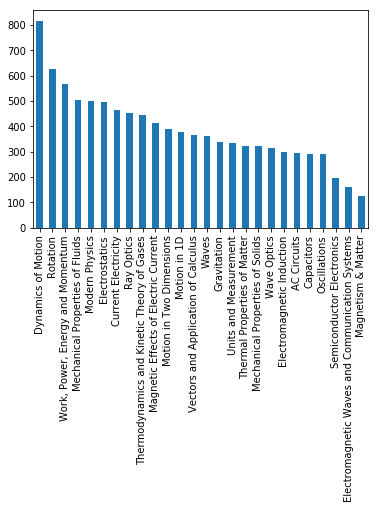

In [3]:
trainDF.label.value_counts().plot(kind="bar")

## Train test split

In [4]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'], test_size=0.2)
print(len(train_x), len(valid_x) )

8061 2016


## Create pipeline for vectorizer & classifier

Label encoding is not needed. All sklearn classifiers are capable of mutli-class classification. Source :  https://stackoverflow.com/questions/51525043/encoding-labels-for-multi-class-problems-in-sckit-learn

In [5]:
## Custom Tokenizer for Vectorizer (no default by sklearn)
'''
Improves accuracy & f1 score for PHY by 2%
'''
stemmer = nltk.stem.porter.PorterStemmer()    ## May need to download this with "nltk.download('punkt')"
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.translate(remove_punctuation_map)))

## Initializing vectorizer
vec = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3),
                      lowercase=True, tokenizer=normalize, max_features=10000, 
                      use_idf = True, min_df = 5, max_df = 0.8, stop_words = None)
## Can't add stop words here as the text is normalized and it won't match the stop words list. Should remove earlier.
## https://stackoverflow.com/questions/57340142/user-warning-your-stop-words-may-be-inconsistent-with-your-preprocessing

## Initializaing classifier
#clf = naive_bayes.MultinomialNB()                                                        ## Accuracy 60%
clf = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg', C=7.5)     ## Accuracy 75.9%
#clf = xgb.XGBClassifier(objective="multi:softprob", random_state=42)           ## Hyper-param opt too slow, worse than base
#clf = RandomForestClassifier(n_estimators=120, max_depth=7, min_samples_leaf=10,          ## Base accuracy 27%
#                             max_features=0.7, n_jobs=-1, oob_score=True)      ## Too slow with 100+ trees
#clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-2,                               ## Accuracy 73.4%
#                    random_state=42, max_iter=4, tol=None)


## Setting up pipeline
pipe = make_pipeline(vec, clf)
pipe.fit(train_x, train_y)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=10000, min_df=5,
        ngram_range=(2, 3), norm='l2', preprocessor=None, smoot...ty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))])

## Prediction & Evaluation metrics

In [6]:
pred_y = pipe.predict(valid_x)
report = metrics.classification_report(valid_y, pred_y)
print(report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(valid_y, pred_y)))
print("F1-score (weighted): {:0.3f}".format(metrics.f1_score(valid_y, pred_y, average = 'weighted')))
## Support is the number of occurrences of each class in valid_y

                                                 precision    recall  f1-score   support

                                    AC Circuits       0.78      0.83      0.80        63
                                     Capacitors       0.90      0.71      0.79        62
                            Current Electricity       0.72      0.81      0.76        94
                             Dynamics of Motion       0.61      0.80      0.69       156
                      Electromagnetic Induction       0.72      0.57      0.64        51
Electromagnetic Waves and Communication Systems       0.74      0.47      0.57        30
                                 Electrostatics       0.77      0.84      0.80       109
                                    Gravitation       0.97      0.86      0.91        71
           Magnetic Effects of Electric Current       0.80      0.74      0.77        96
                             Magnetism & Matter       0.45      0.25      0.32        20
                Mech

This is a higher accuracy than the baseline Naive Bayes model made earlier !
It can be attributed to the Logistic Regression model, along with custom tokenizer better hyper parameters

### Confusion Matrix

In [7]:
metrics.confusion_matrix(valid_y, pred_y)

array([[ 52,   0,   5,   0,   3,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1,   0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  1,  44,   3,   2,   1,   0,  10,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  5,   1,  76,   0,   0,   0,   2,   0,   0,   0,   0,   1,   1,
          1,   0,   0,   0,   0,   3,   3,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0, 125,   1,   0,   1,   0,   0,   0,   2,   0,   3,
          2,   3,   0,   1,   5,   0,   0,   0,   0,   1,   0,   1,  11],
       [  4,   0,   5,   0,  29,   0,   3,   0,   9,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1],
       [  1,   2,   1,   3,   0,  14,   0,   0,   0,   0,   0,   0,   3,
          0,   0,   0,   2,   0,   0,   0,   0,   0,   1,   0,   3,   0],
       [  0,   2,   0,   2,   0,   0,  92,   0,   1,   0,   0,   0,   1,
          1,   0,   0,   0,   1,   1,   0,   

### Hyper-parameter optimization 
#### xgb hyper-params (don't run locally)

In [8]:
'''
## This will consume 100% CPU, run on Kaggle / server
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

vec.fit(trainDF['text'])
xtrain_tfidf_ngram =  vec.transform(train_x)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = model_selection.RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200,
                            cv=3, verbose=1, n_jobs=1, return_train_score=True)

#search.fit(train_x[:,np.newaxis], train_y)
search.fit(xtrain_tfidf_ngram, train_y)

report_best_scores(search.cv_results_, 1)
'''

'\n## This will consume 100% CPU, run on Kaggle / server\ndef report_best_scores(results, n_top=3):\n    for i in range(1, n_top + 1):\n        candidates = np.flatnonzero(results[\'rank_test_score\'] == i)\n        for candidate in candidates:\n            print("Model with rank: {0}".format(i))\n            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(\n                  results[\'mean_test_score\'][candidate],\n                  results[\'std_test_score\'][candidate]))\n            print("Parameters: {0}".format(results[\'params\'][candidate]))\n            print("")\n            \nxgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)\n\nvec.fit(trainDF[\'text\'])\nxtrain_tfidf_ngram =  vec.transform(train_x)\n\nparams = {\n    "colsample_bytree": uniform(0.7, 0.3),\n    "gamma": uniform(0, 0.5),\n    "learning_rate": uniform(0.03, 0.3), # default 0.1 \n    "max_depth": randint(2, 6), # default 3\n    "n_estimators": randint(100, 150), # default 

#### Chapters that were never predicted

In [9]:
set(valid_y) - set(pred_y)

set()

### Check + and - weights of the model, and which feature contribute to prediction
Manually

In [10]:
'''
for i, tag in enumerate(clf.classes_):
    coefficients = clf.coef_[i]
    weights = list(zip(vec.get_feature_names(),coefficients))
    print('Tag:',tag)
    print('Most Positive Coefficients:')
    print(sorted(weights,key=lambda x: -x[1])[:10])
    print('Most Negative Coefficients:')
    print(sorted(weights,key=lambda x: x[1])[:10])
    print("--------------------------------------")
'''

'\nfor i, tag in enumerate(clf.classes_):\n    coefficients = clf.coef_[i]\n    weights = list(zip(vec.get_feature_names(),coefficients))\n    print(\'Tag:\',tag)\n    print(\'Most Positive Coefficients:\')\n    print(sorted(weights,key=lambda x: -x[1])[:10])\n    print(\'Most Negative Coefficients:\')\n    print(sorted(weights,key=lambda x: x[1])[:10])\n    print("--------------------------------------")\n'

#### +ve and -ve Weights using eli5

In [11]:
import eli5
eli5.show_weights(clf, vec=vec, top=50)

## Misclassified Examples

In [12]:
valid = pd.concat([valid_x, valid_y], axis=1)
valid['pred'] = pred_y
valid.head(10)

,text,label,pred
6136,particle of mass m moves from to c under action of force vec f xy widehat i y widehat j along different paths as shown in figure then,"Work, Power, Energy and Momentum","Work, Power, Energy and Momentum"
1453,long hollow conducting cylinder is kept coaxially inside another long hollow conducting cylinder of larger radius both cylinders are initially electrically neutral,Electrostatics,Rotation
4337,unit of time is,Units and Measurement,Units and Measurement
8398,mass m shown in figure oscillates in simple harmonic motion with amplitude find amplitude of point p,Oscillations,Oscillations
4270,man grows into giant such that his linear dimensions increase by factor of assuming that his density remains same stress in leg change by factor of,Mechanical Properties of Solids,Semiconductor Electronics
8899,equation of plane progressive wave motion is y sin left omega t kx right velocity of particle is,Waves,Waves
5075,three identical particles are joined together by thread as shown in figure all three particles are moving in horizontal plane and if velocity of outermost particle is u then ratio of tensions in three sections of string is,Dynamics of Motion,Dynamics of Motion
3928,electrons move at right angles to magnetic field of tesla with speed of m s if specific charge of electron is coulomb kg radius of circular path be,Magnetic Effects of Electric Current,Magnetic Effects of Electric Current
8819,wave in which medium vibrates at right angles to direction of its propagation is called,Waves,Wave Optics
9676,car starting from rest accelerates with ms then what is its velocity after seconds,Motion in 1D,Motion in 1D


In [13]:
misclassified_examples = valid[valid.label != valid.pred]
misclassified_examples.head()

,text,label,pred
1453,long hollow conducting cylinder is kept coaxially inside another long hollow conducting cylinder of larger radius both cylinders are initially electrically neutral,Electrostatics,Rotation
4270,man grows into giant such that his linear dimensions increase by factor of assuming that his density remains same stress in leg change by factor of,Mechanical Properties of Solids,Semiconductor Electronics
8819,wave in which medium vibrates at right angles to direction of its propagation is called,Waves,Wave Optics
3388,ring of radius r is placed in plane with its centre at origin and its axis along x axis and having uniformly distributed positive charge ring of radius r r and coaxial with larger ring is moving along axis with constant velocity then variation of electrical flux left phi right passing through smaller ring with position be represented by,Electromagnetic Induction,Electrostatics
7207,barometer kept in stationary level shows mm then same barometer placed in lift going upwards with constant show reading,Mechanical Properties of Fluids,Motion in 1D


#### Checking 2nd row

In [14]:
eli5.show_prediction(clf, misclassified_examples['text'].values[1], vec=vec)

## Fit models on entire dataset 

In [15]:
len(vec.get_feature_names())

10000

In [16]:
pipe.fit(trainDF['text'], trainDF['label'])

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=10000, min_df=5,
        ngram_range=(2, 3), norm='l2', preprocessor=None, smoot...ty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))])

In [17]:
len(vec.get_feature_names())

10000

### Serialize trained model to disk

In [18]:
## Encoder not needed for sklearn models
## Vectorizer
#with open('vec_phy.pkl', 'wb') as f:
#    pickle.dump(vec, f, pickle.HIGHEST_PROTOCOL)
## Classifer
with open('clf_phy.pkl', 'wb') as f:
    pickle.dump(clf, f, pickle.HIGHEST_PROTOCOL)
## Repo for similar questions
with open('repo_phy.pkl', 'wb') as f:
    pickle.dump(data_df, f, pickle.HIGHEST_PROTOCOL)